In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === 1. Cargar el CSV ===
df = pd.read_csv("df_nn.csv", parse_dates=["Fecha"])

# === 2. Filtrar fechas v√°lidas ===
df2024=df.copy()
df = df[(df["Fecha"] >= "2014-01-01") & (df["Fecha"] <= "2023-12-31")].copy()

# === 3. Eliminar valores negativos
df = df[df["Energia_GWh"] >= 0]

# === 4. Crear columna Mes
df["Mes"] = df["Fecha"].dt.to_period("M").dt.to_timestamp()

# === 5. Identificar series v√°lidas (>=119 meses)
series = df.groupby(["Latitud", "Longitud", "Grupo_Consumo"])["Mes"].nunique().reset_index()
series.columns = ["Lat", "Lon", "Grupo", "Meses_disponibles"]
series_validas = series[series["Meses_disponibles"] >= 119]

# === 6. Filtrar DataFrame a solo series v√°lidas
df = df.merge(series_validas, how="inner", left_on=["Latitud", "Longitud", "Grupo_Consumo"],
              right_on=["Lat", "Lon", "Grupo"])
df = df.drop(columns=["Meses_disponibles", "Lat", "Lon", "Grupo"])

# === 7. Agrupar por provincia + grupo + mes
df_grouped = df.groupby(["Mes", "Grupo_Consumo", "Latitud", "Longitud"], as_index=False)["Energia_GWh"].sum()

# === 8. Agregar estacionalidad
df_grouped["Mes_num"] = df_grouped["Mes"].dt.month
df_grouped["Mes_sin"] = np.sin(2 * np.pi * df_grouped["Mes_num"] / 12)
df_grouped["Mes_cos"] = np.cos(2 * np.pi * df_grouped["Mes_num"] / 12)

# === 9. Codificar grupo de consumo
le_grupo = LabelEncoder()
df_grouped["Grupo_Consumo_Cod"] = le_grupo.fit_transform(df_grouped["Grupo_Consumo"])

# === 10. Verificar
print(df_grouped.head())
print("Series v√°lidas:", df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"]).ngroups)

         Mes      Grupo_Consumo  Latitud  Longitud  Energia_GWh  Mes_num  \
0 2014-01-01  Alumbrado P√∫blico  -3.9931  -79.2042     2.431179        1   
1 2014-01-01  Alumbrado P√∫blico  -2.9006  -79.0045     6.909779        1   
2 2014-01-01  Alumbrado P√∫blico  -2.5489  -78.9382     0.701441        1   
3 2014-01-01  Alumbrado P√∫blico  -2.2301  -80.8599     2.157857        1   
4 2014-01-01  Alumbrado P√∫blico  -2.1709  -79.9224    15.365893        1   

   Mes_sin   Mes_cos  Grupo_Consumo_Cod  
0      0.5  0.866025                  0  
1      0.5  0.866025                  0  
2      0.5  0.866025                  0  
3      0.5  0.866025                  0  
4      0.5  0.866025                  0  
Series v√°lidas: 112


In [ ]:
from tqdm import tqdm
import numpy as np

# === 1. Inicializaci√≥n ===
n_steps = 12
X_total, y_total = [], []
grupo_input_total = []
fechas_total = []
serie_clave_total = []

# === 2. Generar secuencias por serie ===
grupos = df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"])

for (lat, lon, grupo_cod), group in tqdm(grupos, desc="Procesando series"):
    group = group.sort_values("Mes").reset_index(drop=True)

    if len(group) < n_steps + 1:
        continue

    for i in range(len(group) - n_steps):
        ventana = group.iloc[i:i + n_steps]
        target = group.iloc[i + n_steps]["Energia_GWh"]
        fecha_target = group.iloc[i + n_steps]["Mes"]

        secuencia = ventana[["Energia_GWh", "Mes_sin", "Mes_cos", "Latitud", "Longitud"]].values

        X_total.append(secuencia)
        y_total.append(target)
        grupo_input_total.append(grupo_cod)
        fechas_total.append(fecha_target)
        serie_clave_total.append((lat, lon, grupo_cod))

# === 3. Convertir a arrays ===
X_total = np.array(X_total)
y_total = np.array(y_total)
grupo_input_total = np.array(grupo_input_total)
fechas_total = np.array(fechas_total)
serie_clave_total = np.array(serie_clave_total)

# === 4. Dividir por fecha (test = desde 2023-01-01) ===
fechas_total_ts = pd.to_datetime(fechas_total)
fecha_corte = pd.Timestamp("2023-01-01")

mask_train = fechas_total_ts < fecha_corte
mask_test = fechas_total_ts >= fecha_corte

X_train = X_total[mask_train]
y_train = y_total[mask_train]
grupo_train = grupo_input_total[mask_train]
fechas_train = fechas_total[mask_train]
clave_train = serie_clave_total[mask_train]

X_test = X_total[mask_test]
y_test = y_total[mask_test]
grupo_test = grupo_input_total[mask_test]
fechas_test = fechas_total[mask_test]
clave_test = serie_clave_total[mask_test]

# === 5. Verificar ===
print("‚úÖ Divisi√≥n por fecha aplicada correctamente:")
print("Entrenamiento:", fechas_train.min(), "‚Üí", fechas_train.max())
print("Test:", fechas_test.min(), "‚Üí", fechas_test.max())
print("X_train:", X_train.shape, " | X_test:", X_test.shape)


Procesando series: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 112/112 [00:13<00:00,  8.22it/s]


‚úÖ Divisi√≥n por fecha aplicada correctamente:
Entrenamiento: 2015-01-01 00:00:00 ‚Üí 2022-12-01 00:00:00
Test: 2023-01-01 00:00:00 ‚Üí 2023-12-01 00:00:00
X_train: (10734, 12, 5)  | X_test: (1339, 12, 5)


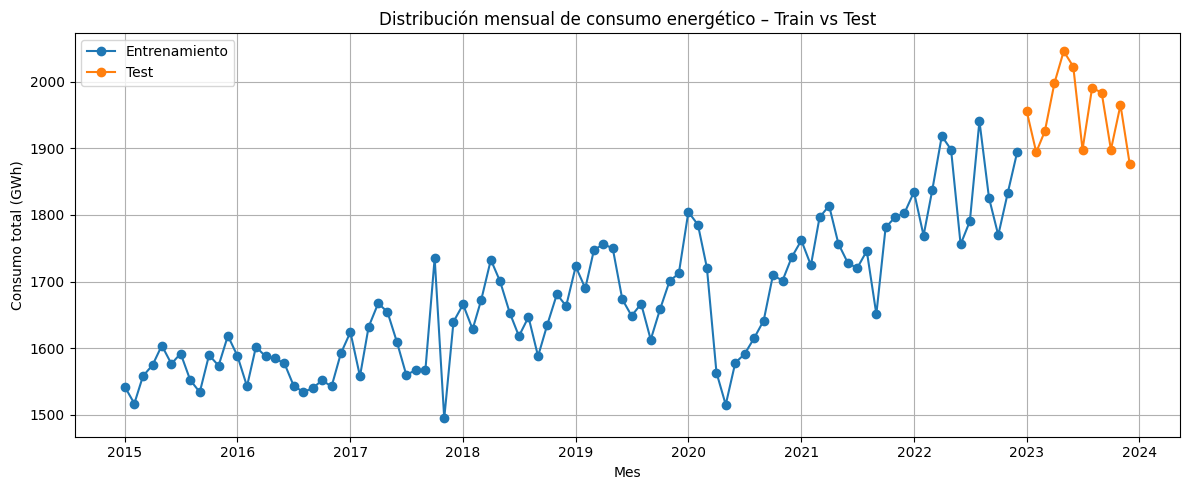

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Crear DataFrame para entrenamiento
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train,
    "Tipo": "Entrenamiento"
})

# === 2. Crear DataFrame para test
df_test_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Energia_GWh": y_test,
    "Tipo": "Test"
})

# === 3. Unir ambos DataFrames
df_plot = pd.concat([df_train_plot, df_test_plot])
df_plot["Mes"] = pd.to_datetime(df_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 4. Agrupar por mes y tipo
df_mes = df_plot.groupby(["Mes", "Tipo"])["Energia_GWh"].sum().reset_index()

# === 5. Graficar
plt.figure(figsize=(12, 5))
for tipo in df_mes["Tipo"].unique():
    datos = df_mes[df_mes["Tipo"] == tipo]
    plt.plot(datos["Mes"], datos["Energia_GWh"], label=f"{tipo}", marker="o")

plt.title("Distribuci√≥n mensual de consumo energ√©tico ‚Äì Train vs Test")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, RepeatVector, Flatten, Bidirectional, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Definir entradas ===
input_seq_shape = (X_train.shape[1], X_train.shape[2])  # ahora ser√° (18, 5)
num_grupos = len(np.unique(grupo_input_total))
embedding_dim = 4

seq_input = Input(shape=input_seq_shape, name="seq_input")
grupo_input = Input(shape=(1,), name="grupo_input")

# === 2. Embedding para grupo ===
grupo_embedding = Embedding(input_dim=num_grupos, output_dim=embedding_dim)(grupo_input)
grupo_embedding_flat = Flatten()(grupo_embedding)
grupo_embedding_repeated = RepeatVector(input_seq_shape[0])(grupo_embedding_flat)

# === 3. Concatenar ===
merged = Concatenate()([seq_input, grupo_embedding_repeated])

# === 4. Bi-LSTM + Dropout
x = Bidirectional(LSTM(128, return_sequences=True))(merged)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(64))(x)

# === 5. Dense con LeakyReLU
x = Dense(64)(x)
x = LeakyReLU()(x)
x = Dense(32)(x)
x = LeakyReLU()(x)
output = Dense(1)(x)

# === 6. Compilar modelo
model = Model(inputs=[seq_input, grupo_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

early_stop = EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)

history = model.fit(
    {"seq_input": X_train, "grupo_input": grupo_train},
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ grupo_input         ‚îÇ (None, 1)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding           ‚îÇ (None, 1, 4)      ‚îÇ         20 ‚îÇ grupo_input[0][0] ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)   ‚îÇ (None, 4)         ‚îÇ          0 ‚îÇ embedding[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ seq_input           ‚îÇ (None, 12, 5)     ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ repeat_vector       ‚îÇ (None, 12, 4)     ‚îÇ          0 ‚îÇ flatten[0][0]     ‚îÇ
‚îÇ (RepeatVector)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 12, 9)     ‚îÇ          0 ‚îÇ seq_input[0][0],  ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ repeat_vector[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional       ‚îÇ (None, 12, 256)   ‚îÇ    141,312 ‚îÇ concatenate[0][0] ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)   ‚îÇ (None, 12, 256)   ‚îÇ          0 ‚îÇ bidirectional[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1     ‚îÇ (None, 128)       ‚îÇ    164,352 ‚îÇ dropout[0][0]     ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 316,053 (1.21 MB)

 Trainable params: 316,053 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
151/151 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 95ms/step - loss: 663.5123 - mae: 8.7522 - val_loss: 1.3176 - val_mae: 0.8955
Epoch 2/100
151/151 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 91ms/step - loss: 17.0176 - mae: 1.7208 - val_loss: 2.1236 - val_mae: 1.1975
Epoch 3/100
151/151 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 20s 89ms/step - loss: 12.1182 - mae: 1.4357 - val_loss: 1.5318 - val_mae: 1.0159
Epoch 4/100
151/151 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 93ms/step - loss: 11.8819 - mae: 1.4087 - val_loss: 2.4212 - val_mae: 1.2096
Epoch 5/100
151/151 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 104ms/step - loss: 13.9893 - mae: 1.5290 - val_loss: 1.3474 - val_mae: 0.8155
Epoch 6/100
151/151 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 94ms/step - loss: 10.2290 - mae: 1.4084 - val_loss: 0.9849 - val_mae: 0.6267
Epoch 7/100
151/151 ‚îÅ‚îÅ

42/42 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 38ms/step
üìä M√âTRICAS TEST ‚Äì SOLO 2023:
‚úÖ MAE  : 58.23 GWh
‚úÖ RMSE : 64.92 GWh
‚úÖ MAPE : 2.96 %
‚úÖ R¬≤   : -0.4786


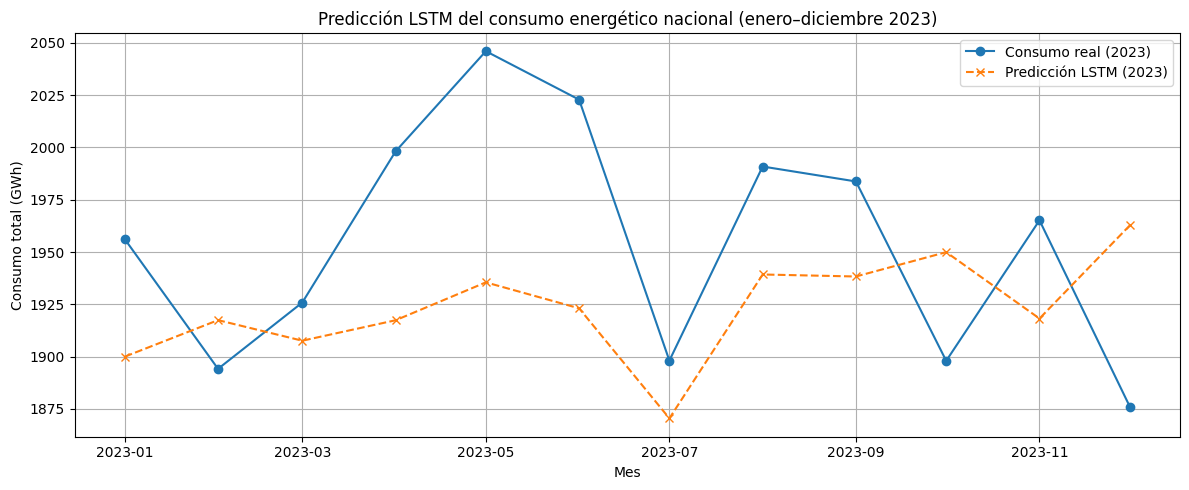

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Predicci√≥n sobre test ===
y_pred_test = model.predict({"seq_input": X_test, "grupo_input": grupo_test}).flatten()

# === 2. DataFrame con resultados
df_test_resultados = pd.DataFrame({
    "Fecha": fechas_test,
    "Real": y_test,
    "Pred": y_pred_test
})
df_test_resultados["Mes"] = pd.to_datetime(df_test_resultados["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 3. Agrupar por mes a nivel nacional
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum()

# === 4. M√©tricas
mae = mean_absolute_error(df_test_mensual["Real"], df_test_mensual["Pred"])
rmse = np.sqrt(mean_squared_error(df_test_mensual["Real"], df_test_mensual["Pred"]))
mape = mean_absolute_percentage_error(df_test_mensual["Real"], df_test_mensual["Pred"]) * 100
r2 = r2_score(df_test_mensual["Real"], df_test_mensual["Pred"])

print("üìä M√âTRICAS TEST ‚Äì SOLO 2023:")
print(f"‚úÖ MAE  : {mae:.2f} GWh")
print(f"‚úÖ RMSE : {rmse:.2f} GWh")
print(f"‚úÖ MAPE : {mape:.2f} %")
print(f"‚úÖ R¬≤   : {r2:.4f}")

# === 5. Gr√°fica
plt.figure(figsize=(12, 5))
plt.plot(df_test_mensual.index, df_test_mensual["Real"], label="Consumo real (2023)", marker="o")
plt.plot(df_test_mensual.index, df_test_mensual["Pred"], label="Predicci√≥n LSTM (2023)", marker="x", linestyle="--")
plt.title("Predicci√≥n LSTM del consumo energ√©tico nacional (enero‚Äìdiciembre 2023)")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


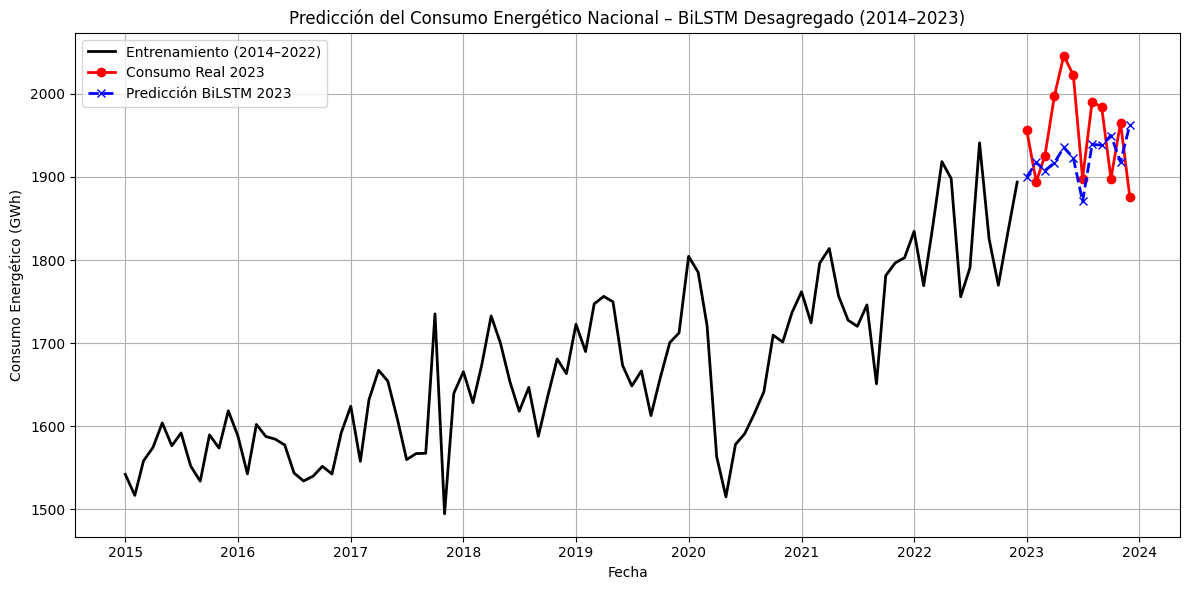

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Agrupar entrenamiento por mes (ya que solo tenemos valores reales por muestra)
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train
})
df_train_plot["Mes"] = pd.to_datetime(df_train_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()
df_train_mensual = df_train_plot.groupby("Mes")["Energia_GWh"].sum().reset_index()
df_train_mensual.columns = ["Mes", "Real_GWh"]

# === 2. Preparar test con predicci√≥n (ya lo tienes)
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum().reset_index()
df_test_mensual.columns = ["Mes", "Real_GWh", "Prediccion_GWh"]

# === 3. Unir ambas fases
df_entrenamiento = df_train_mensual.copy()
df_test_real = df_test_mensual[["Mes", "Real_GWh"]]
df_test_pred = df_test_mensual[["Mes", "Prediccion_GWh"]]

# === 4. Graficar
plt.figure(figsize=(12, 6))

# Real entrenamiento (2014‚Äì2022)
plt.plot(df_entrenamiento["Mes"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014‚Äì2022)", color="black", linewidth=2)

# Real test (2023)
plt.plot(df_test_real["Mes"], df_test_real["Real_GWh"],
         label="Consumo Real 2023", color="red", marker="o", linewidth=2)

# Predicci√≥n LSTM
plt.plot(df_test_pred["Mes"], df_test_pred["Prediccion_GWh"],
         label="Predicci√≥n BiLSTM 2023", color="blue", linestyle="--", marker="x", linewidth=2)

# Est√©tica
plt.title("Predicci√≥n del Consumo Energ√©tico Nacional ‚Äì BiLSTM Desagregado (2014‚Äì2023)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energ√©tico (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# 2024

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# === 1. Cargar el CSV ===
df = pd.read_csv("df_nn.csv", parse_dates=["Fecha"])

# === 2. Filtrar fechas v√°lidas ===
df2024=df.copy()
df = df[(df["Fecha"] >= "2014-01-01") & (df["Fecha"] <= "2024-12-31")].copy()

# === 3. Eliminar valores negativos
df = df[df["Energia_GWh"] >= 0]

# === 4. Crear columna Mes
df["Mes"] = df["Fecha"].dt.to_period("M").dt.to_timestamp()

# === 5. Identificar series v√°lidas (>=119 meses)
series = df.groupby(["Latitud", "Longitud", "Grupo_Consumo"])["Mes"].nunique().reset_index()
series.columns = ["Lat", "Lon", "Grupo", "Meses_disponibles"]
series_validas = series[series["Meses_disponibles"] >= 119]

# === 6. Filtrar DataFrame a solo series v√°lidas
df = df.merge(series_validas, how="inner", left_on=["Latitud", "Longitud", "Grupo_Consumo"],
              right_on=["Lat", "Lon", "Grupo"])
df = df.drop(columns=["Meses_disponibles", "Lat", "Lon", "Grupo"])

# === 7. Agrupar por provincia + grupo + mes
df_grouped = df.groupby(["Mes", "Grupo_Consumo", "Latitud", "Longitud"], as_index=False)["Energia_GWh"].sum()

# === 8. Agregar estacionalidad
df_grouped["Mes_num"] = df_grouped["Mes"].dt.month
df_grouped["Mes_sin"] = np.sin(2 * np.pi * df_grouped["Mes_num"] / 12)
df_grouped["Mes_cos"] = np.cos(2 * np.pi * df_grouped["Mes_num"] / 12)

# === 9. Codificar grupo de consumo
le_grupo = LabelEncoder()
df_grouped["Grupo_Consumo_Cod"] = le_grupo.fit_transform(df_grouped["Grupo_Consumo"])

# === 10. Verificar
print(df_grouped.head())
print("Series v√°lidas:", df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"]).ngroups)

         Mes      Grupo_Consumo  Latitud  Longitud  Energia_GWh  Mes_num  \
0 2014-01-01  Alumbrado P√∫blico  -3.9931  -79.2042     2.431179        1   
1 2014-01-01  Alumbrado P√∫blico  -3.2596  -79.9585     5.421740        1   
2 2014-01-01  Alumbrado P√∫blico  -2.9006  -79.0045     6.909779        1   
3 2014-01-01  Alumbrado P√∫blico  -2.5489  -78.9382     0.701441        1   
4 2014-01-01  Alumbrado P√∫blico  -2.2301  -80.8599     2.157857        1   

   Mes_sin   Mes_cos  Grupo_Consumo_Cod  
0      0.5  0.866025                  0  
1      0.5  0.866025                  0  
2      0.5  0.866025                  0  
3      0.5  0.866025                  0  
4      0.5  0.866025                  0  
Series v√°lidas: 114


In [ ]:
from tqdm import tqdm
import numpy as np

# === 1. Inicializaci√≥n ===
n_steps = 12
X_total, y_total = [], []
grupo_input_total = []
fechas_total = []
serie_clave_total = []

# === 2. Generar secuencias por serie ===
grupos = df_grouped.groupby(["Latitud", "Longitud", "Grupo_Consumo_Cod"])

for (lat, lon, grupo_cod), group in tqdm(grupos, desc="Procesando series"):
    group = group.sort_values("Mes").reset_index(drop=True)

    if len(group) < n_steps + 1:
        continue

    for i in range(len(group) - n_steps):
        ventana = group.iloc[i:i + n_steps]
        target = group.iloc[i + n_steps]["Energia_GWh"]
        fecha_target = group.iloc[i + n_steps]["Mes"]

        secuencia = ventana[["Energia_GWh", "Mes_sin", "Mes_cos", "Latitud", "Longitud"]].values

        X_total.append(secuencia)
        y_total.append(target)
        grupo_input_total.append(grupo_cod)
        fechas_total.append(fecha_target)
        serie_clave_total.append((lat, lon, grupo_cod))

# === 3. Convertir a arrays ===
X_total = np.array(X_total)
y_total = np.array(y_total)
grupo_input_total = np.array(grupo_input_total)
fechas_total = np.array(fechas_total)
serie_clave_total = np.array(serie_clave_total)

# === 4. Dividir por fecha (test = desde 2023-01-01) ===
fechas_total_ts = pd.to_datetime(fechas_total)
fecha_corte = pd.Timestamp("2024-01-01")

mask_train = fechas_total_ts < fecha_corte
mask_test = fechas_total_ts >= fecha_corte

X_train = X_total[mask_train]
y_train = y_total[mask_train]
grupo_train = grupo_input_total[mask_train]
fechas_train = fechas_total[mask_train]
clave_train = serie_clave_total[mask_train]

X_test = X_total[mask_test]
y_test = y_total[mask_test]
grupo_test = grupo_input_total[mask_test]
fechas_test = fechas_total[mask_test]
clave_test = serie_clave_total[mask_test]

# === 5. Verificar ===
print("‚úÖ Divisi√≥n por fecha aplicada correctamente:")
print("Entrenamiento:", fechas_train.min(), "‚Üí", fechas_train.max())
print("Test:", fechas_test.min(), "‚Üí", fechas_test.max())
print("X_train:", X_train.shape, " | X_test:", X_test.shape)

Procesando series: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 114/114 [00:10<00:00, 11.10it/s]


‚úÖ Divisi√≥n por fecha aplicada correctamente:
Entrenamiento: 2015-01-01 00:00:00 ‚Üí 2023-12-01 00:00:00
Test: 2024-01-01 00:00:00 ‚Üí 2024-12-01 00:00:00
X_train: (12283, 12, 5)  | X_test: (1363, 12, 5)


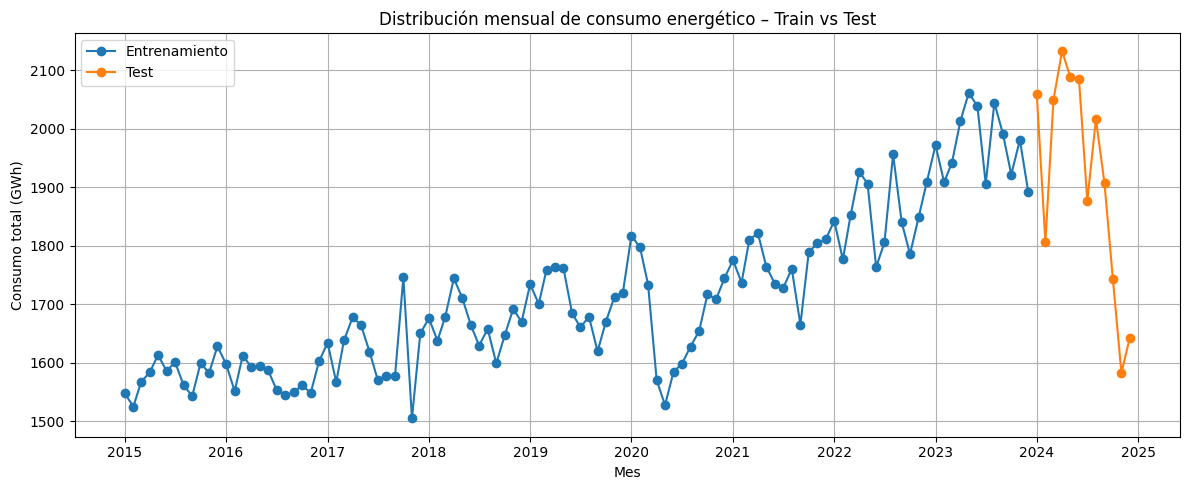

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Crear DataFrame para entrenamiento
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train,
    "Tipo": "Entrenamiento"
})

# === 2. Crear DataFrame para test
df_test_plot = pd.DataFrame({
    "Fecha": fechas_test,
    "Energia_GWh": y_test,
    "Tipo": "Test"
})

# === 3. Unir ambos DataFrames
df_plot = pd.concat([df_train_plot, df_test_plot])
df_plot["Mes"] = pd.to_datetime(df_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 4. Agrupar por mes y tipo
df_mes = df_plot.groupby(["Mes", "Tipo"])["Energia_GWh"].sum().reset_index()

# === 5. Graficar
plt.figure(figsize=(12, 5))
for tipo in df_mes["Tipo"].unique():
    datos = df_mes[df_mes["Tipo"] == tipo]
    plt.plot(datos["Mes"], datos["Energia_GWh"], label=f"{tipo}", marker="o")

plt.title("Distribuci√≥n mensual de consumo energ√©tico ‚Äì Train vs Test")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, RepeatVector, Flatten, Bidirectional, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping

# === 1. Definir entradas ===
input_seq_shape = (X_train.shape[1], X_train.shape[2])
num_grupos = len(np.unique(grupo_input_total))
embedding_dim = 4

# === 2. Capas de entrada ===
seq_input = Input(shape=input_seq_shape, name="seq_input")
grupo_input = Input(shape=(1,), name="grupo_input")

# === 3. Embedding del grupo ===
grupo_embedding = Embedding(input_dim=num_grupos, output_dim=embedding_dim)(grupo_input)
grupo_embedding_flat = Flatten()(grupo_embedding)
grupo_embedding_repeated = RepeatVector(input_seq_shape[0])(grupo_embedding_flat)

# === 4. Combinar entrada secuencia + embedding ===
merged = Concatenate()([seq_input, grupo_embedding_repeated])

# === 5. Capas Bi-LSTM
x = Bidirectional(LSTM(128, return_sequences=True))(merged)
x = Dropout(0.2)(x)
x = Bidirectional(LSTM(64))(x)

# === 6. Capas densas con LeakyReLU
x = Dense(32)(x)
x = LeakyReLU()(x)
output = Dense(1)(x)

# === 7. Modelo y compilaci√≥n
model = Model(inputs=[seq_input, grupo_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])
model.summary()

# === 8. Entrenamiento
early_stop = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)

history = model.fit(
    {"seq_input": X_train, "grupo_input": grupo_train},
    y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Model: "functional"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)        ‚îÉ Output Shape      ‚îÉ    Param # ‚îÉ Connected to      ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ grupo_input         ‚îÇ (None, 1)         ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ embedding           ‚îÇ (None, 1, 4)      ‚îÇ         20 ‚îÇ grupo_input[0][0] ‚îÇ
‚îÇ (Embedding)         ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten (Flatten)   ‚îÇ (None, 4)         ‚îÇ          0 ‚îÇ embedding[0][0]   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ seq_input           ‚îÇ (None, 12, 5)     ‚îÇ          0 ‚îÇ -                 ‚îÇ
‚îÇ (InputLayer)        ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ repeat_vector       ‚îÇ (None, 12, 4)     ‚îÇ          0 ‚îÇ flatten[0][0]     ‚îÇ
‚îÇ (RepeatVector)      ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ concatenate         ‚îÇ (None, 12, 9)     ‚îÇ          0 ‚îÇ seq_input[0][0],  ‚îÇ
‚îÇ (Concatenate)       ‚îÇ                   ‚îÇ            ‚îÇ repeat_vector[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional       ‚îÇ (None, 12, 256)   ‚îÇ    141,312 ‚îÇ concatenate[0][0] ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)   ‚îÇ (None, 12, 256)   ‚îÇ          0 ‚îÇ bidirectional[0]‚Ä¶ ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ bidirectional_1     ‚îÇ (None, 128)       ‚îÇ    164,352 ‚îÇ dropout[0][0]     ‚îÇ
‚îÇ (Bidirectional)     ‚îÇ                   ‚îÇ            ‚îÇ                   ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î

 Total params: 309,845 (1.18 MB)

 Trainable params: 309,845 (1.18 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
173/173 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 29s 117ms/step - loss: 839.3742 - mae: 9.3948 - val_loss: 1.0421 - val_mae: 0.6829
Epoch 2/100
173/173 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 18s 106ms/step - loss: 40.4111 - mae: 1.9606 - val_loss: 1.1489 - val_mae: 0.7424
Epoch 3/100
173/173 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 22s 115ms/step - loss: 21.9556 - mae: 1.6366 - val_loss: 2.4282 - val_mae: 0.9634
Epoch 4/100
173/173 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 19s 105ms/step - loss: 15.3826 - mae: 1.5911 - val_loss: 2.2703 - val_mae: 1.1383
Epoch 5/100
173/173 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 90ms/step - loss: 15.5924 - mae: 1.4952 - val_loss: 0.8096 - val_mae: 0.5022
Epoch 6/100
173/173 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 23s 103ms/step - loss: 16.5714 - mae: 1.4863 - val_loss: 1.3640 - val_mae: 0.8362
Epoch 7/100
173/173 ‚î

43/43 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 30ms/step
üìä M√âTRICAS TEST ‚Äì SOLO 2024:
‚úÖ MAE  : 143.10 GWh
‚úÖ RMSE : 156.30 GWh
‚úÖ MAPE : 7.75 %
‚úÖ R¬≤   : 0.2339


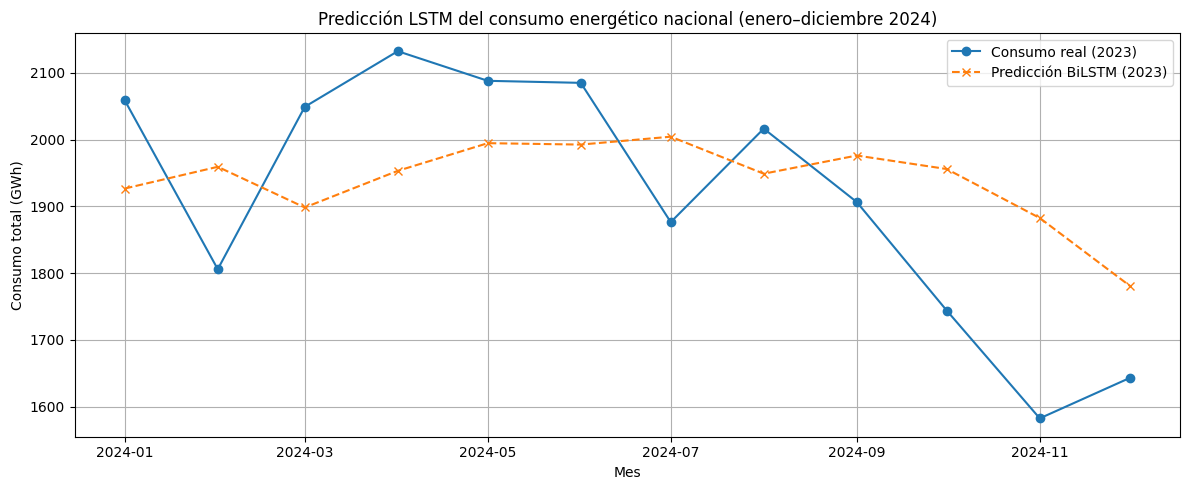

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Predicci√≥n sobre test ===
y_pred_test = model.predict({"seq_input": X_test, "grupo_input": grupo_test}).flatten()

# === 2. DataFrame con resultados
df_test_resultados = pd.DataFrame({
    "Fecha": fechas_test,
    "Real": y_test,
    "Pred": y_pred_test
})
df_test_resultados["Mes"] = pd.to_datetime(df_test_resultados["Fecha"]).dt.to_period("M").dt.to_timestamp()

# === 3. Agrupar por mes a nivel nacional
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum()

# === 4. M√©tricas
mae = mean_absolute_error(df_test_mensual["Real"], df_test_mensual["Pred"])
rmse = np.sqrt(mean_squared_error(df_test_mensual["Real"], df_test_mensual["Pred"]))
mape = mean_absolute_percentage_error(df_test_mensual["Real"], df_test_mensual["Pred"]) * 100
r2 = r2_score(df_test_mensual["Real"], df_test_mensual["Pred"])

print("üìä M√âTRICAS TEST ‚Äì SOLO 2024:")
print(f"‚úÖ MAE  : {mae:.2f} GWh")
print(f"‚úÖ RMSE : {rmse:.2f} GWh")
print(f"‚úÖ MAPE : {mape:.2f} %")
print(f"‚úÖ R¬≤   : {r2:.4f}")

# === 5. Gr√°fica
plt.figure(figsize=(12, 5))
plt.plot(df_test_mensual.index, df_test_mensual["Real"], label="Consumo real (2023)", marker="o")
plt.plot(df_test_mensual.index, df_test_mensual["Pred"], label="Predicci√≥n BiLSTM (2023)", marker="x", linestyle="--")
plt.title("Predicci√≥n LSTM del consumo energ√©tico nacional (enero‚Äìdiciembre 2024)")
plt.xlabel("Mes")
plt.ylabel("Consumo total (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


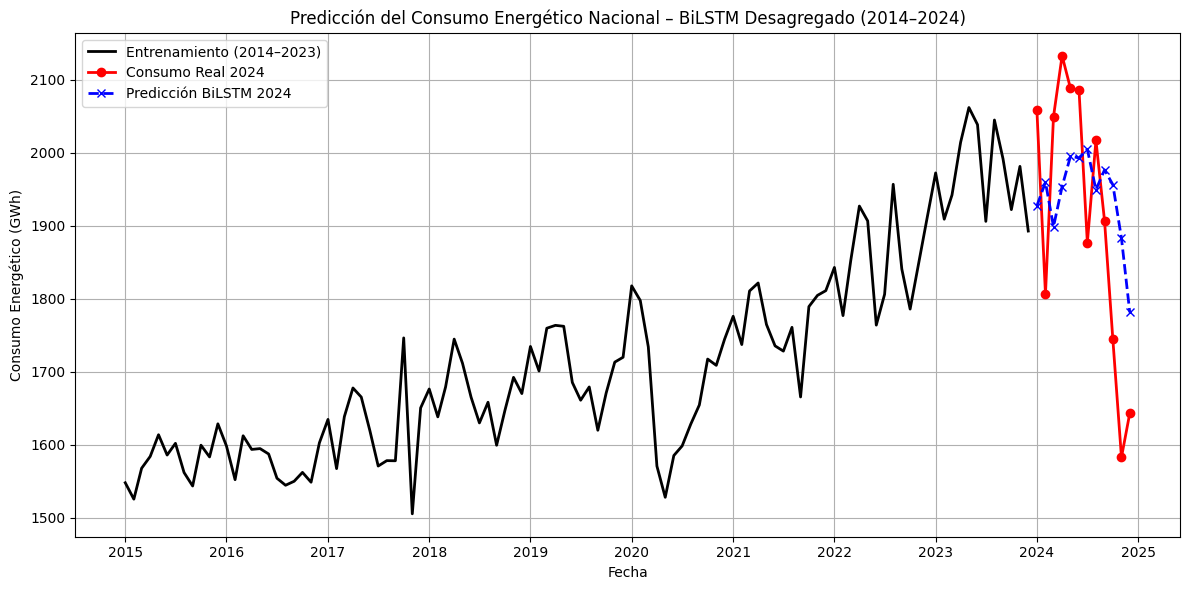

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# === 1. Agrupar entrenamiento por mes (ya que solo tenemos valores reales por muestra)
df_train_plot = pd.DataFrame({
    "Fecha": fechas_train,
    "Energia_GWh": y_train
})
df_train_plot["Mes"] = pd.to_datetime(df_train_plot["Fecha"]).dt.to_period("M").dt.to_timestamp()
df_train_mensual = df_train_plot.groupby("Mes")["Energia_GWh"].sum().reset_index()
df_train_mensual.columns = ["Mes", "Real_GWh"]

# === 2. Preparar test con predicci√≥n (ya lo tienes)
df_test_mensual = df_test_resultados.groupby("Mes")[["Real", "Pred"]].sum().reset_index()
df_test_mensual.columns = ["Mes", "Real_GWh", "Prediccion_GWh"]

# === 3. Unir ambas fases
df_entrenamiento = df_train_mensual.copy()
df_test_real = df_test_mensual[["Mes", "Real_GWh"]]
df_test_pred = df_test_mensual[["Mes", "Prediccion_GWh"]]

# === 4. Graficar
plt.figure(figsize=(12, 6))

# Real entrenamiento (2014‚Äì2022)
plt.plot(df_entrenamiento["Mes"], df_entrenamiento["Real_GWh"],
         label="Entrenamiento (2014‚Äì2023)", color="black", linewidth=2)

# Real test (2023)
plt.plot(df_test_real["Mes"], df_test_real["Real_GWh"],
         label="Consumo Real 2024", color="red", marker="o", linewidth=2)

# Predicci√≥n LSTM
plt.plot(df_test_pred["Mes"], df_test_pred["Prediccion_GWh"],
         label="Predicci√≥n BiLSTM 2024", color="blue", linestyle="--", marker="x", linewidth=2)

# Est√©tica
plt.title("Predicci√≥n del Consumo Energ√©tico Nacional ‚Äì BiLSTM Desagregado (2014‚Äì2024)")
plt.xlabel("Fecha")
plt.ylabel("Consumo Energ√©tico (GWh)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
